In [1]:
from model import model
from model import *

import data_loader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch

%load_ext autoreload
%autoreload 2

Data iteration testing

In [2]:
bs=3
frames = data_loader.get_datasets(32,bs)
imgs= next(iter(frames))

In [3]:
imgs.shape

torch.Size([3, 3, 32, 32])

RDN

In [4]:
c = model.conv_feature_extractor.RDN(3,5,5,3,2)

In [5]:
feats=c(imgs)

Create graph from features

In [6]:
imsize = imgs[0].shape[-1]

In [7]:
grids = torch.cat([x.unsqueeze(0) for x in torch.meshgrid([torch.linspace(-1, 1, imsize) for _ in range(2)])])

In [8]:
batch_coords = grids.unsqueeze(0).repeat(bs,*[1]*len(grids.shape))

In [9]:
batch_coords.shape

torch.Size([3, 2, 32, 32])

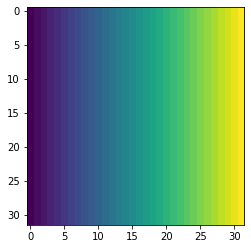

In [10]:
plt.imshow(batch_coords[2][1]);

In [11]:
batch_coords_added = torch.cat([batch_coords,feats],axis=1).detach()

In [12]:
batch_coords_added.shape

torch.Size([3, 7, 32, 32])

In [13]:
batch_coords_added[0][:2][1]

tensor([[-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        ...,
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000]])

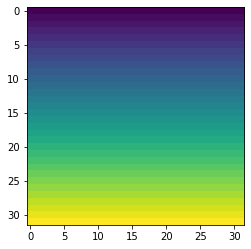

In [14]:
plt.imshow(batch_coords_added[0][0]);

In [15]:
# Maps x,y to index in flattened list
flat_indices = np.arange(imsize**2).reshape((imsize,imsize)) 
# Create flattened adjacency list
adj_list = [[flat_indices[x,y],flat_indices[neighbx,neighby]]
                # For (very cell
                for x,y in [(x,y) for x in range(imsize) for y in range(imsize)]
                    # Every valid neighbor of current cell
                    for neighbx,neighby in [(x+xd,y+yd) for xd in range(-1,2) for yd in range(-1,2) 
                                   if -1<x+xd<imsize and -1<y+yd<imsize] ]
edge_tensor = torch.tensor(adj_list).t().contiguous()

In [16]:
from torch_geometric.data import Data,Batch
from torch_geometric.utils import to_dense_batch

In [17]:
flat_feats = batch_coords_added.flatten(2,3).permute(0,2,1)

In [18]:
t=Batch.from_data_list([Data(x,edge_tensor) for x in flat_feats])

In [19]:
tx=to_dense_batch(t.x,t.batch)[0]

In [20]:
t.x.shape,t.batch.shape,tx.shape

(torch.Size([3072, 7]), torch.Size([3072]), torch.Size([3, 1024, 7]))

In [21]:
tx.shape

torch.Size([3, 1024, 7])

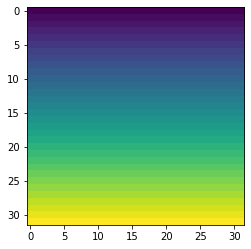

In [24]:
plt.imshow( tx[0,:,0].reshape(32,32) );
#plt.imshow( tx.permute(0,2,1)[0][0].reshape(32,32) );

Softmax grid-ization

In [47]:
batch_coords.shape

NameError: name 'batch_coords' is not defined

In [22]:
inp = tx[:,:,:2]
crds=batch_coords.flatten(2,3).permute(0,2,1)
inp.shape,crds.shape

(torch.Size([3, 1024, 2]), torch.Size([3, 1024, 2]))

In [23]:
score=1/(1+torch.cdist(inp,crds).permute(0,1,2))
score.shape

torch.Size([3, 1024, 1024])

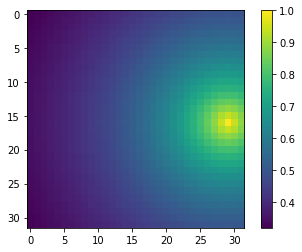

In [183]:
from numpy import random
i=random.randint(0,1023)
i=541
plt.imshow(score[0][i].reshape(32,32))
plt.colorbar()

torch.Size([3, 1024, 1024]) torch.Size([1024, 1024, 3])


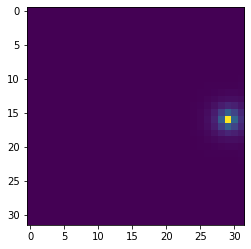

In [191]:
soft_score=torch.nn.Softmax(dim=1)(20*score)
print(soft_score.shape,soft_score.T.shape)
plt.imshow(soft_score[0][i].reshape(32,32))

In [186]:
# soft_score[batch_idx][pixel_idx] holds weights for input to pixel_idx

In [228]:
weight_feats=torch.matmul(soft_score,inp)
(weight_feats).shape,weight_feats.sum(dim=2).shape

(torch.Size([3, 1024, 2]), torch.Size([3, 1024]))

In [226]:
soft_score.shape,tx.shape

(torch.Size([3, 1024, 1024]), torch.Size([3, 1024, 7]))

Graph module testing

In [73]:
from model.model import model as mm

In [74]:
m = mm(32,3).cuda()

In [75]:
out=m(imgs)

In [77]:
out.shape

torch.Size([3, 1024, 3])